In [1]:
using Random, Distributions
using LinearAlgebra, Statistics
using CSV, DataFrames
using Plots

In [2]:
γ = 0.2
β = 0.8 # 4% interest rate, 5 years

df = DataFrame(CSV.File("/Users/yinyin/Documents/GitHub/Practice/firm_dynamics/bds2018_sector_fage.csv",delim=','))
d = filter([:year, :sector] => (year,sector) -> year==2018 && sector == "44-45" ,df)

,year,sector,fage,firms,estabs,emp,denom,estabs_entry
,Int64,String,String,Int64,Int64,Int64,Int64,String
1,2018,44-45,a) 0,43132,43449,193935,96968,43449
2,2018,44-45,b) 1,36043,36596,182127,185175,63
3,2018,44-45,c) 2,32769,33649,190511,192813,1189
4,2018,44-45,d) 3,28670,29817,188771,192942,1025
5,2018,44-45,e) 4,26064,27532,185633,187887,931
6,2018,44-45,f) 5,23174,24217,162477,165576,724
7,2018,44-45,g) 6 to 10,90776,97963,786885,802178,2477
8,2018,44-45,h) 11 to 15,74236,84918,763098,769537,1820
9,2018,44-45,i) 16 to 20,50111,63855,634190,644065,1500


If we take variable cost to be wL and normalize w=1. Then log(VC)=log(L), meanwhile we have $$VC = \frac{q^{1+\gamma}}{(1+\gamma)s}$$ 
so $$log(VC)= (1+\gamma)log(q) - log(1+\gamma) - log(s) $$,  

Also, note that firms' optimal decision of $q$ is $q = (p*s)^(1/γ)$, so we have $log(q)= \frac{1}{\gamma}(log(p)+log(s))$, so we have

$$ log(L) = \frac{1+\gamma}{\gamma}(log(p)+log(s)) - log(1+\gamma) - log(s) $$
$$ log(L) = 1/\gamma  log(s) + \frac{1+\gamma}{\gamma}log(p) - log(1+\gamma) $$
$$ log(s) = \gamma log(L) - (1+\gamma)log(p) + \gamma*log(1+\gamma) $$

Since we have $log(s_{t=1}) = \rho log(s_{t}) + \epsilon_{t}$, we have

$$ \gamma log(L_{t+1}) - (1+\gamma)log(p) + \gamma*log(1+\gamma) = \rho [\gamma log(L_{t}) - (1+\gamma)log(p) + \gamma*log(1+\gamma)]  + \epsilon_{t+1}$$

$$ log(L_{t+1}) = \rho log(L_{t}) + A + \frac{1}{\gamma}\epsilon_{t+1}  $$

In [3]:
firms = zeros(6) # 6 age cohorts: entrants, 1-5, 6-10, 11-15, 16-20, 21-25
emp = zeros(6)
deaths = zeros(6)

firms[1] = d.firms[1]*5
emp[1] = d.emp[1]*5
deaths[1] =0

firms[2] = sum(d.firms[2:6])
emp[2] = sum(d.emp[2:6])
deaths[2] = sum(parse.(Int64, d.firmdeath_firms[2:6]))

for i in 3:6
    firms[i] = d.firms[4+i]
    emp[i] = d.emp[4+i]
    deaths[i] = parse(Int64, d.firmdeath_firms[4+i])
end

avg_emp = emp./(firms-deaths) # average employment for surviving firms
lemp = log.(avg_emp)

using GLM

X = lemp[1:5]
Y = lemp[2:6]

# plot(X,Y)

data = DataFrame(X=X,Y=Y)
lm(@formula(Y ~ X), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Y ~ 1 + X

Coefficients:
───────────────────────────────────────────────────────────────────────
                Coef.  Std. Error     t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────
(Intercept)  0.599082    0.417623  1.43    0.2469  -0.729981    1.92815
X            0.865704    0.190756  4.54    0.0200   0.258635    1.47277
───────────────────────────────────────────────────────────────────────

In [4]:
ρ = 0.866
σ = γ*sqrt(var(lemp)*5/4*(1-ρ^2)) # = 0.06
σ_0 = sqrt(σ^2/(1 - ρ^2)) # 0.12
m = (0.6 - ρ *log(1+γ))*γ # assume p=1, m = 0.09

# parameters left to calibrate: c_e, f, m_0

0.08842190636328706

In [5]:
# moments to match

mom = zeros(5)
for i in 1:5
    mom[i] = (firms[i+1]-deaths[i+1])/firms[1]
end

# probability to survive till age 1, 2, 3: α_1,  α_3,  α_5

In [6]:
# Discretize AR(1) - Tauchen Method

function tauchen(m, σ, ρ=0.866, n_std = 8, N = 100)
    # Discretize space
    m_s = m/(1-ρ)
    σ_s = σ/sqrt(1-ρ^2)
    s_min = m_s - n_std * σ_s/2
    s_max = m_s + n_std * σ_s
    log_s = range(s_min, s_max, length = N)
    s = exp.(log_s)
    d = log_s[2] - log_s[1]
    d_half = d/2
    
    # Tranformation matrix
    P = zeros(N,N)
    for i in eachindex(log_s) 
        P[i,1] = cdf(Normal(0,1), (s_min + d_half -ρ*log_s[i]-m)/σ)
        P[i,N] = 1 - cdf(Normal(0,1), (s_max - d_half -ρ*log_s[i]-m)/σ)
        for j in 2:N-1
            P[i,j] = cdf(Normal(0,1), (log_s[j] + d_half -ρ*log_s[i]-m)/σ) - cdf(Normal(0,1), (log_s[j]  - d_half -ρ*log_s[i]-m)/σ)
        end    
    end
    return P,s
end

tauchen (generic function with 4 methods)

In [7]:
(P,s) = tauchen(m, σ);

In [8]:
# Find Value Function

function findV(p, V0, P, s, f, γ=0.2, β=0.8, max_it = 1e4, tol=1e-8)
    i = 1 
    dist = 1e3
    V = V0
    N = length(s)
    
    # optimal q
    q = (p*s).^(1/γ)
    # profit function
    profit = p*q - (q.^(1+γ))./((1+γ)*s)-f*ones(N)
    
    while (i < max_it) & (dist > tol)
        V1 =  max.(0, profit + β * P'*V)
        dist = norm(V1 - V)
        V = V1
        i += 1
    end
    
    return V
    
end

findV (generic function with 5 methods)

In [9]:
function fr_entry(p, P, s, c_e, g, f)
    V0 = zeros(N)
    V = findV(p, V0, P, s, f)
    return  β*g'*V - c_e
end

fr_entry (generic function with 1 method)

In [10]:
function eqm_price(P, s, c_e, g, f, max_it = 1e3, tol=1e-8)
    p_max = 100
    p_min = 0
    v_e = 1e3
    i = 0
    
    while (i < max_it) & (p_max - p_min > tol)
        p = (p_max + p_min)/2
        v_e = fr_entry(p, P, s, c_e, g, f)
        if v_e > 0
            p_max = p
        else
            p_min = p
        end
        i +=1
    end
    
    return p_min
end

eqm_price (generic function with 3 methods)

In [11]:
# Exit threshold

function exit_s(p, s, P, f)
    v = -1
    # optimal q
    q = (p*s).^(1/γ)
    # profit function
    profit = p*q - (q.^(1+γ))./((1+γ)*s)-f*ones(N)
    
    V0 = zeros(N)
    V = profit + β*P'*findV(p, V0, P, s, f)
    
    return sum(V.<0)
end

exit_s (generic function with 1 method)

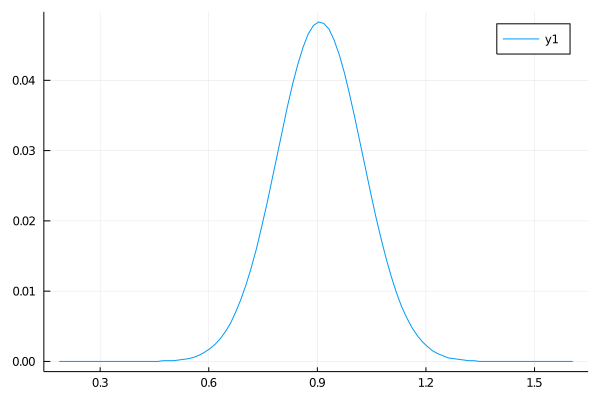

In [12]:
# moments 

N = length(s)
    
    # Initial distribution
    G = cdf(LogNormal(0.9,σ_0),s)
    g = zeros(N)
    g[1] = G[1]

    for i in 2:N
        g[i] = G[i] - G[i-1]
    end
    g=round.(g/sum(g),digits=4);

plot(log.(s),g)

In [13]:
# moments 

N = length(s)

function Moments(f, c_e, m_0)
    
    # Initial distribution
    G = cdf(LogNormal(m_0,σ_0),s)
    g = zeros(N)
    g[1] = G[1]

    for i in 2:N
        g[i] = G[i] - G[i-1]
    end
    g=round.(g/sum(g),digits=4);

    
    price = eqm_price(P, s, c_e, g, f)
    # Exit rule
    k = exit_s(price,s, P, f)
    s_star = s[k+1]
    
    P_tilde = zeros(N,N)
    # g_tilde = zeros(N)
    for i in k+1:N
        P_tilde[i,:] = P[i,:]
        # g_tilde[i] = g[i]
    end
    
    # Invariant distribution
    μ=inv(I-P_tilde')*g
    
    α = zeros(5)
    MU = zeros(5,N)

    for i in eachindex(α)
        MU[i,:] = (P_tilde')^(i) * g
        α[i] = sum(MU[i,:])/sum(g)
    end

    return α  
end

Moments (generic function with 1 method)

In [14]:
c_e = 5:5:100
f = 5:5:100
m_0 = 0.1:0.1:1.5

0.1:0.1:1.5

In [15]:
i_star = 1
j_star = 1
k_star = 1
di = 1e3

for i in eachindex(f)
    for j in eachindex(c_e)
        for k in eachindex(m_0)
            # print("i", i,"j",j,"k",k)
            di_new = norm(Moments(f[i], c_e[j], m_0[k]) - mom)
            if di_new < di
                di = di_new
                i_star = i
                j_star = j
                k_star = k
            end  
        end
    end
end

print(di)
print("i",i_star,"j", j_star,"k", k_star)
print("f:", f[i_star]," c_e:", c_e[j_star]," m_0:", m_0[k_star])

0.060207500693780364i6j5k9f:30 c_e:25 m_0:0.9

In [16]:
mom

5-element Array{Float64,1}:
 0.5711072985254567
 0.38122507650932025
 0.31800055643141983
 0.2167022164518223
 0.18196234814059167

In [17]:
Moments(f[1], c_e[1], m_0[9])

5-element Array{Float64,1}:
 0.6309369063093673
 0.4834869761511682
 0.36292496428217896
 0.2667283350440341
 0.19274453309348336

In [18]:
Moments(f[6], c_e[6], m_0[9])

5-element Array{Float64,1}:
 0.6309369063093673
 0.4834869761511682
 0.36292496428217896
 0.2667283350440341
 0.19274453309348336

In [19]:
Moments(f[3], c_e[3], m_0[9])

5-element Array{Float64,1}:
 0.6309369063093673
 0.4834869761511682
 0.36292496428217896
 0.2667283350440341
 0.19274453309348336